muSIMtypes

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

# import pandas as pd
import awkward
from uproot_methods import TLorentzVectorArray
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.uproothelpers import fromNestNestIndexArray

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import json
import os
from os.path import join

########## backgrounds ##########
# bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_nonempty_v2.json')))
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbkg_bTags.json'))) # skim
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
# datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/control_data2018_v2.json')))
datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_v2.json')))
datadatasets = datadatasets_
datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
# datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
# mapping.update(datamapping)
####################################

In [3]:
# using regular expressions on dataset name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!data)')

# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [1]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        musim_axis = hist.Bin('code', 'mu sim code', 24, -12, 12)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
            'musim': hist.Hist('Counts', dataset_axis, musim_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolation05'].content,
            ncands=df['pfjet_pfcands_n'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral]
        
        ljpfmuidx = awkward.fromiter(df['pfjet_pfcand_pfmuonIdx'])
        haspfmu = (awkward.JaggedArray.fromoffsets(ljpfmuidx.offsets, ljpfmuidx.flatten().counts)>0)
        ljpfmuSimtype = fromNestNestIndexArray(df['muon_simType'], ljpfmuidx)
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        ljpfmuSimtype = ljpfmuSimtype[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_
        ljpfmuSimtype = ljpfmuSimtype
        
            
#         output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
#         output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
#         output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
#         output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        ljmuwgt = (ljpfmuSimtype.ones_like()*wgt).flatten().flatten()
        ljmuchannel = (ljpfmuSimtype.ones_like()*channel_).flatten().flatten()
        output['musim'].fill(dataset=dataset, code=ljpfmuSimtype.flatten().flatten(), weight=ljmuwgt, channel=ljmuchannel)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

NameError: name 'np' is not defined

In [32]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 25/25 [00:03<00:00,  8.27items/s]


In [51]:
def makeplot(varname, title, overflow='none', logy=True, ylim=None):
    fig, axes=plt.subplots(1,2,figsize=(16,6))
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('symlog')
            ax.autoscale(axis='y', tight=True)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.set_xlim([-5, 6])
        ax.set_xticks(np.array([-4, 0, 3, 4])+0.5)
        ax.set_xticklabels(['GhostPrimaryMuon', 'NotMatched', 'MatchedMuonFromHeavyFlavour', 'MatchedPrimaryMuon'],
                           rotation=20, fontdict=dict(horizontalalignment='right'))
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)
    axes[0].set_title(f'[2mu2e] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu] leptonjets {title}', x=0.0, ha="left")

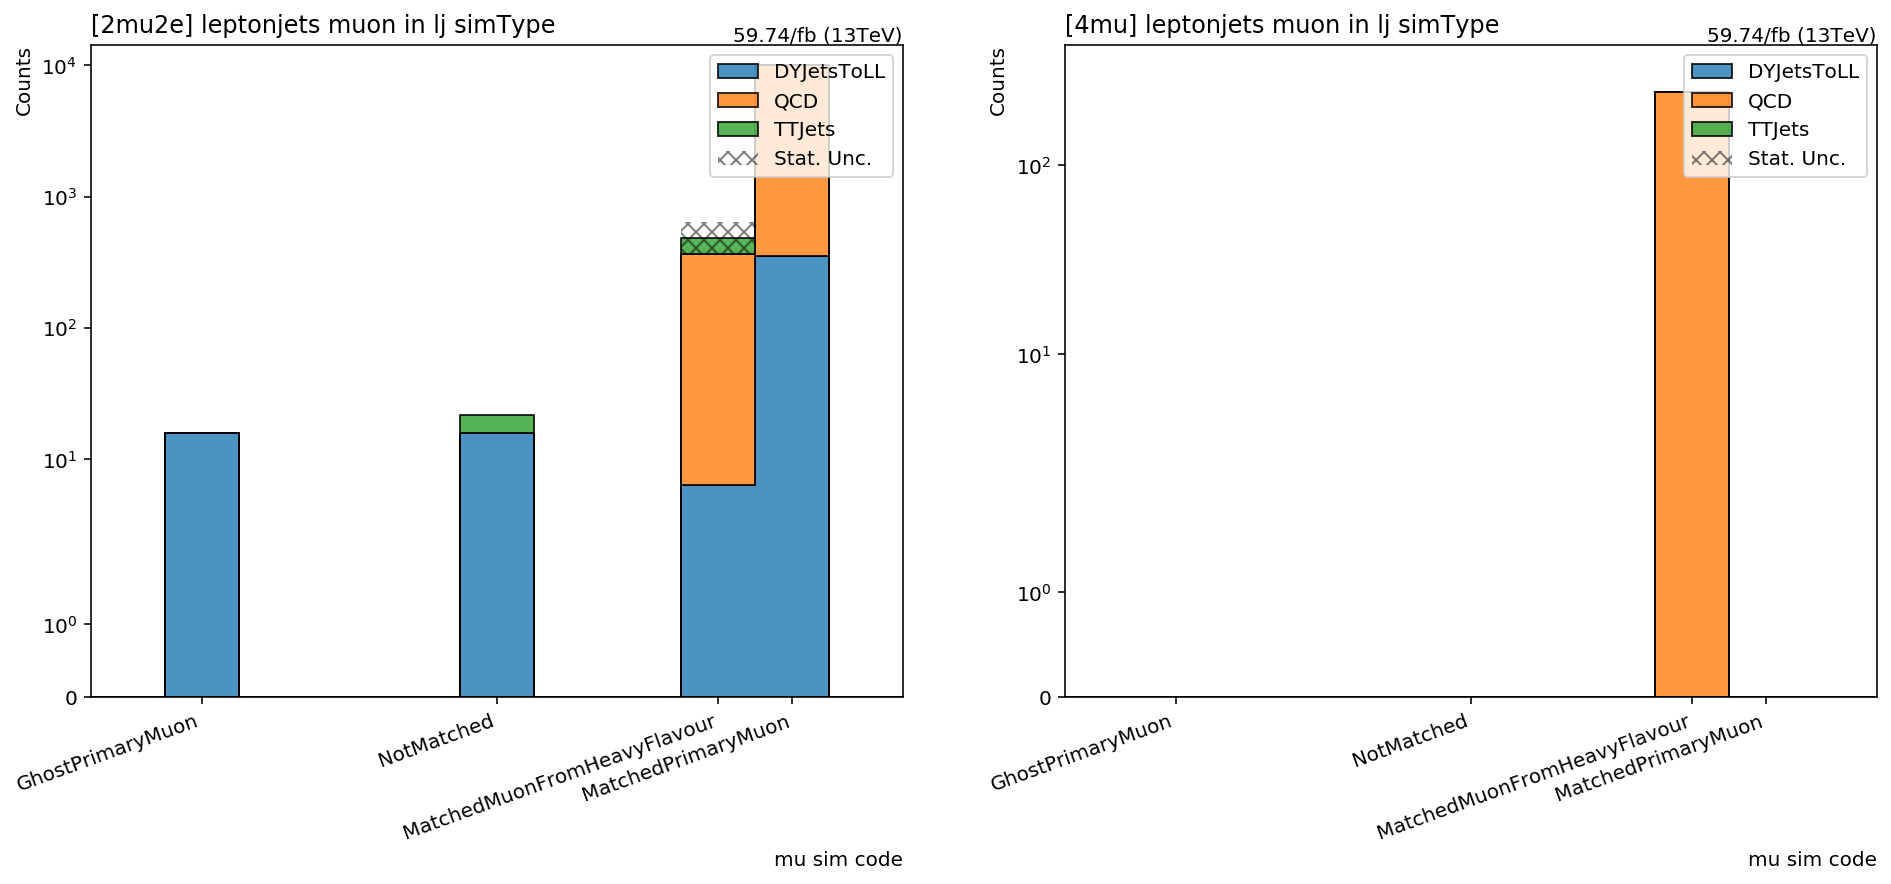

In [52]:
makeplot('musim', 'muon in lj simType', overflow='all', logy=True, ylim=None)

# signal

In [21]:
dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))

In [53]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 30, -np.pi, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        musim_axis = hist.Bin('code', 'mu sim code', 24, -12, 12)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
            'musim': hist.Hist('Counts', dataset_axis, musim_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
#         if len(dataset)!=1:
#             wgts.add('genw', df['weight'])
        
        triggermask = np.logical_and.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            pfiso=df['pfjet_pfIsolation05'].content,
            ncands=df['pfjet_pfcands_n'].content,
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral]
        
        ljpfmuidx = awkward.fromiter(df['pfjet_pfcand_pfmuonIdx'])
        haspfmu = (awkward.JaggedArray.fromoffsets(ljpfmuidx.offsets, ljpfmuidx.flatten().counts)>0)
        ljpfmuSimtype = fromNestNestIndexArray(df['muon_simType'], ljpfmuidx)
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        ljpfmuSimtype = ljpfmuSimtype[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        
        leptonjets_ = dileptonjets
        if leptonjets_.size==0: return output
        wgt = wgt
        lj0 = lj0
        lj1 = lj1
        channel_ = channel_
        ljpfmuSimtype = ljpfmuSimtype
        
            
#         output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
#         output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
#         output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
#         output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        ljmuwgt = (ljpfmuSimtype.ones_like()*wgt).flatten().flatten()
        ljmuchannel = (ljpfmuSimtype.ones_like()*channel_).flatten().flatten()
        output['musim'].fill(dataset=dataset, code=ljpfmuSimtype.flatten().flatten(), weight=ljmuwgt, channel=ljmuchannel)
        
        return output
    
    def postprocess(self, accumulator):
#         origidentity = list(accumulator)        
#         for k in origidentity:
#             accumulator[k].scale(bkgscales, axis='dataset')
#             accumulator[k+'_cat'] = accumulator[k].group("dataset",
#                                                          hist.Cat("cat", "datasets"),
#                                                          mapping)
        return accumulator

In [54]:
dataset={
    '4mu/mXX-100_mA-5_lxy-300': dataset4mu_['mXX-100_mA-5_lxy-300'],
    '4mu/mXX-1000_mA-0p25_lxy-300': dataset4mu_['mXX-1000_mA-0p25_lxy-300'],
    '2mu2e/mXX-100_mA-5_lxy-300':dataset2mu2e_['mXX-100_mA-5_lxy-300'],
    '2mu2e/mXX-1000_mA-0p25_lxy-300': dataset2mu2e_['mXX-1000_mA-0p25_lxy-300'],
    
    '4mu/mXX-100_mA-5_lxy-0p3': dataset4mu_['mXX-100_mA-5_lxy-0p3'],
    '4mu/mXX-1000_mA-0p25_lxy-0p3': dataset4mu_['mXX-1000_mA-0p25_lxy-0p3'],
    '2mu2e/mXX-100_mA-5_lxy-0p3': dataset2mu2e_['mXX-100_mA-5_lxy-0p3'],
    '2mu2e/mXX-1000_mA-0p25_lxy-0p3': dataset2mu2e_['mXX-1000_mA-0p25_lxy-0p3'],
}

output = processor.run_uproot_job(dataset,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=False),
                                  chunksize=500000,
                                  maxchunks=1
                                 )

Processing: 100%|██████████| 16/16 [00:06<00:00,  2.66items/s]


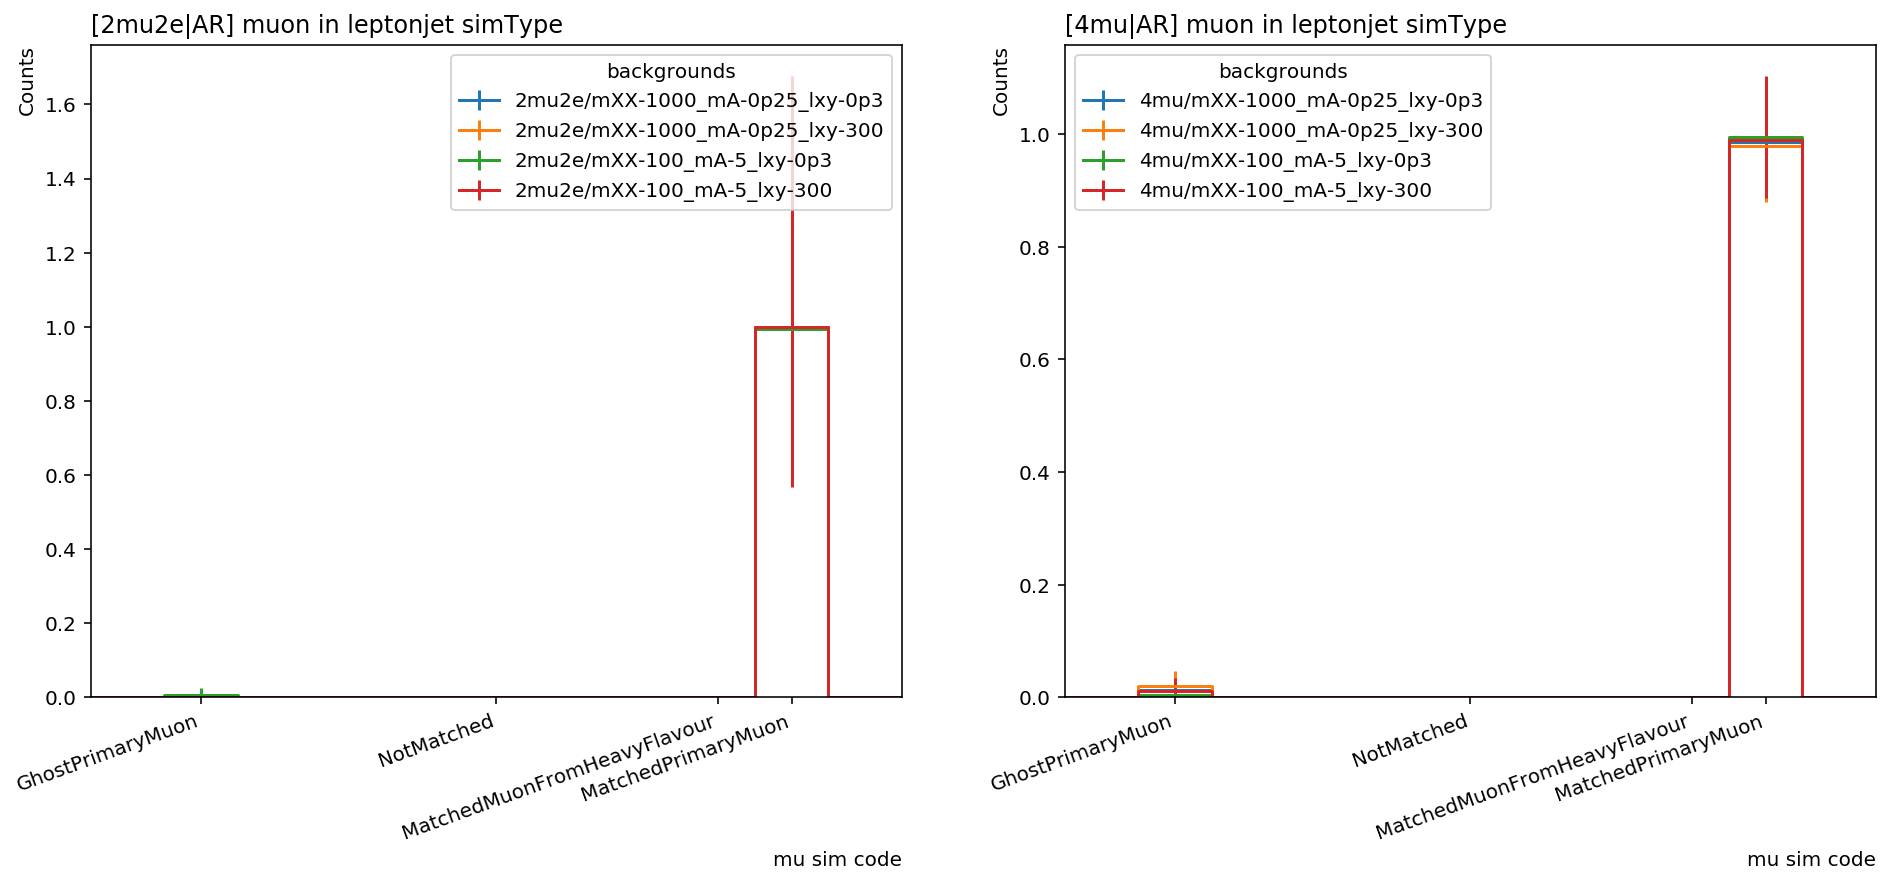

In [55]:
fig, axes=plt.subplots(1,2, figsize=(16,6))
hist.plot1d(output['musim']['2mu2e/*'].integrate('channel', slice(1,2)),
                   overlay='dataset',
                   ax=axes[0],
                   density=True,
                   overflow='all',)
hist.plot1d(output['musim']['4mu/*'].integrate('channel', slice(2,3)),
                   overlay='dataset',
                   ax=axes[1],
                   density=True,
                   overflow='all',)
# ax.set_yscale('symlog')
for ax in axes:
    ax.set_xlabel(ax.get_xlabel(), x=1, ha='right')
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
    ax.set_xlim([-5, 6])
    ax.set_xticks(np.array([-4, 0, 3, 4])+0.5)
    ax.set_xticklabels(['GhostPrimaryMuon', 'NotMatched', 'MatchedMuonFromHeavyFlavour', 'MatchedPrimaryMuon'],
                       rotation=20, fontdict=dict(horizontalalignment='right'))
# ax.text(1,1,'59.74/fb (13TeV)',ha='right', va='bottom', transform=ax.transAxes)
axes[0].set_title('[2mu2e|AR] muon in leptonjet simType', x=0.0, ha="left")
axes[1].set_title('[4mu|AR] muon in leptonjet simType', x=0.0, ha="left");